<a href="https://colab.research.google.com/github/ralfeteo/ebac-teo/blob/main/Computa%C3%A7%C3%A3o%20em%20nuvem%20II%20exercicio_respondido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Computação em Nuvem II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>AWS Lambda;</li>
  <li>AWS Step Functions;</li>
  <li>AWS EventBridge.</li>
</ol>

---

# **Exercícios**

## 1\. AWS Lambda

In [ ]:
#Bucket bronze

import json
import logging
from datetime import datetime

import boto3
import urllib3
from botocore.exceptions import ClientError

def lambda_handler(event, context) -> bool:

 # -- setup

 URL = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.4392/dados'

 BRONZE_BUCKET = 'modulo-39-ebac-bronze-teo'

 client = boto3.client('s3')

 date = datetime.now().strftime('%Y-%m-%d')
 filename_json = f'stock-exchange-{date}.json'

 # -- extract

 try:
  http = urllib3.PoolManager()
  response = http.request(url=URL, method='get')
 except Exception as exc:
  raise exc
 else:
  data = json.loads(response.data.decode())
  logging.info(msg=data)

 # -- transform

 ...

 # -- load

 try:
   with open(f'/tmp/{filename_json}', mode='w', encoding='utf8') as fp:
     json.dump(data, fp)
   client.upload_file(Filename=f'/tmp/{filename_json}', Bucket=BRONZE_BUCKET, Key=filename_json)
 except ClientError as exc:
   raise exc

 return json.dumps(dict(status=True))

In [ ]:
#Bucket silver

import json
from datetime import datetime
import boto3
from botocore.exceptions import ClientError

def lambda_handler(event, context) -> bool:

    # -- setup
    BRONZE_BUCKET = 'modulo39-ebac-bronze-teo'
    SILVER_BUCKET = 'modulo39-ebac-silver-teo'

    client = boto3.client('s3')

    date = datetime.now().strftime('%Y-%m-%d')
    filename_csv = f'stock-exchange-{date}.csv'
    filename_json = f'stock-exchange-{date}.json'

    # -- extract
    client.download_file(BRONZE_BUCKET, filename_json, f'/tmp/{filename_json}')

    with open(f"/tmp/{filename_json}", mode='r', encoding='utf8') as fp:
        data = json.load(fp)

    # -- transform
    for record in data:
      if 'data' in record:
            record['valor'] = record['valor'].replace(',', '.')
            record['data'] = datetime.strptime(record['data'], '%d/%m/%Y').strftime('%Y-%m-%d')

    # -- load
    try:
        with open(f'/tmp/{filename_csv}', mode='w', encoding='utf8') as fp:
            for record in data:
                fp.write(','.join([str(v) for v in record.values()]) + '\n')
        client.upload_file(Filename=f'/tmp/{filename_csv}', Bucket=SILVER_BUCKET, Key=f'data_referencia={date}/{filename_csv}')
    except ClientError as exc:
        raise exc

    return json.dumps(dict(status=True))

In [ ]:
#Tabela Athena

import json
from datetime import datetime

import boto3
from botocore.exceptions import ClientError

def lambda_handler(event, context) -> bool:

  # -- setup

  SILVER_BUCKET = 'modulo39-ebac-silver-teo'

  query = f"""
  CREATE EXTERNAL TABLE IF NOT EXISTS cdi (
    data string,
    valor double
  )
  PARTITIONED BY (
    data_referencia string
  )
  ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
  WITH SERDEPROPERTIES ('separatorChar'=',')
  LOCATION 's3://{SILVER_BUCKET}/'
  """

  client = boto3.client('athena')

  # -- create

  try:
    client.start_query_execution(
      QueryString=query,
      ResultConfiguration={'OutputLocation': 's3://ebac-iris-teo/ '}
    )
  except ClientError as exc:
    raise exc

  # -- update

  try:
    client.start_query_execution(
      QueryString='MSCK REPAIR TABLE cdi',
      ResultConfiguration={'OutputLocation': 's3://ebac-iris-teo/ '}
    )
  except ClientError as exc:
    raise exc

  return json.dumps(dict(status=True))

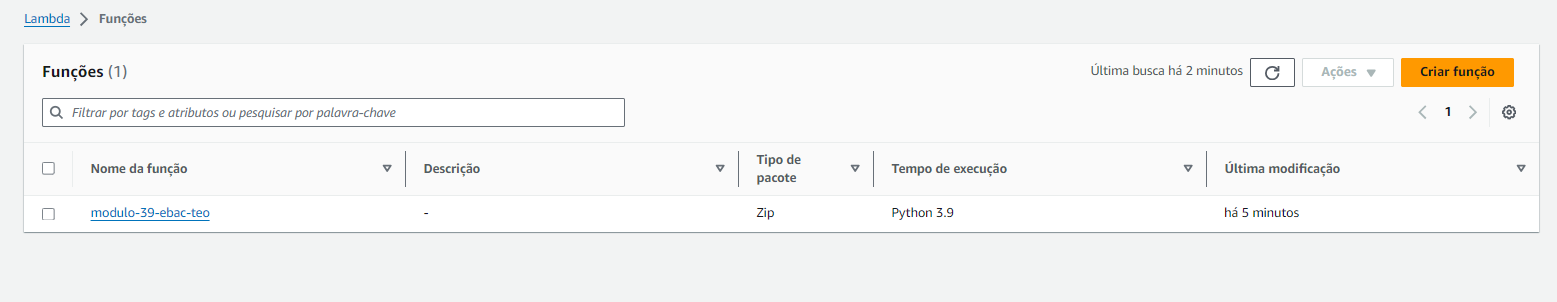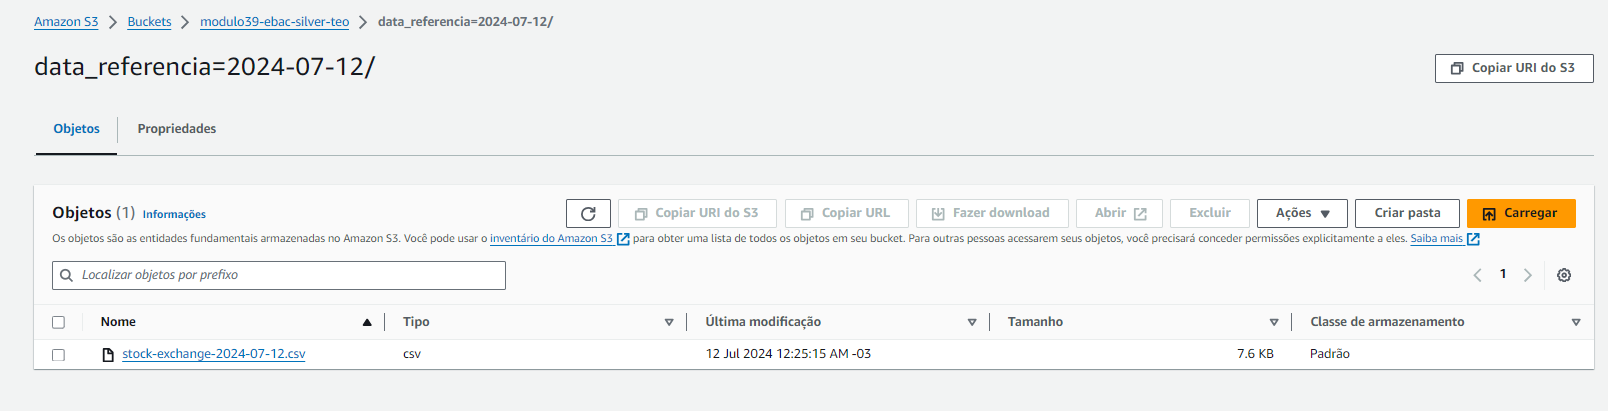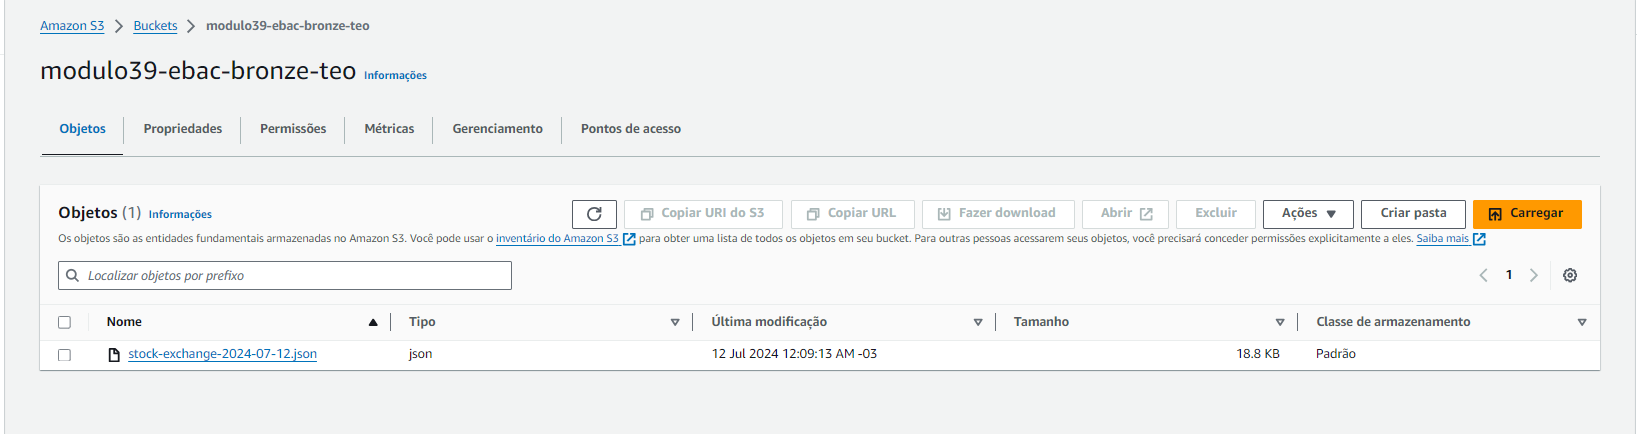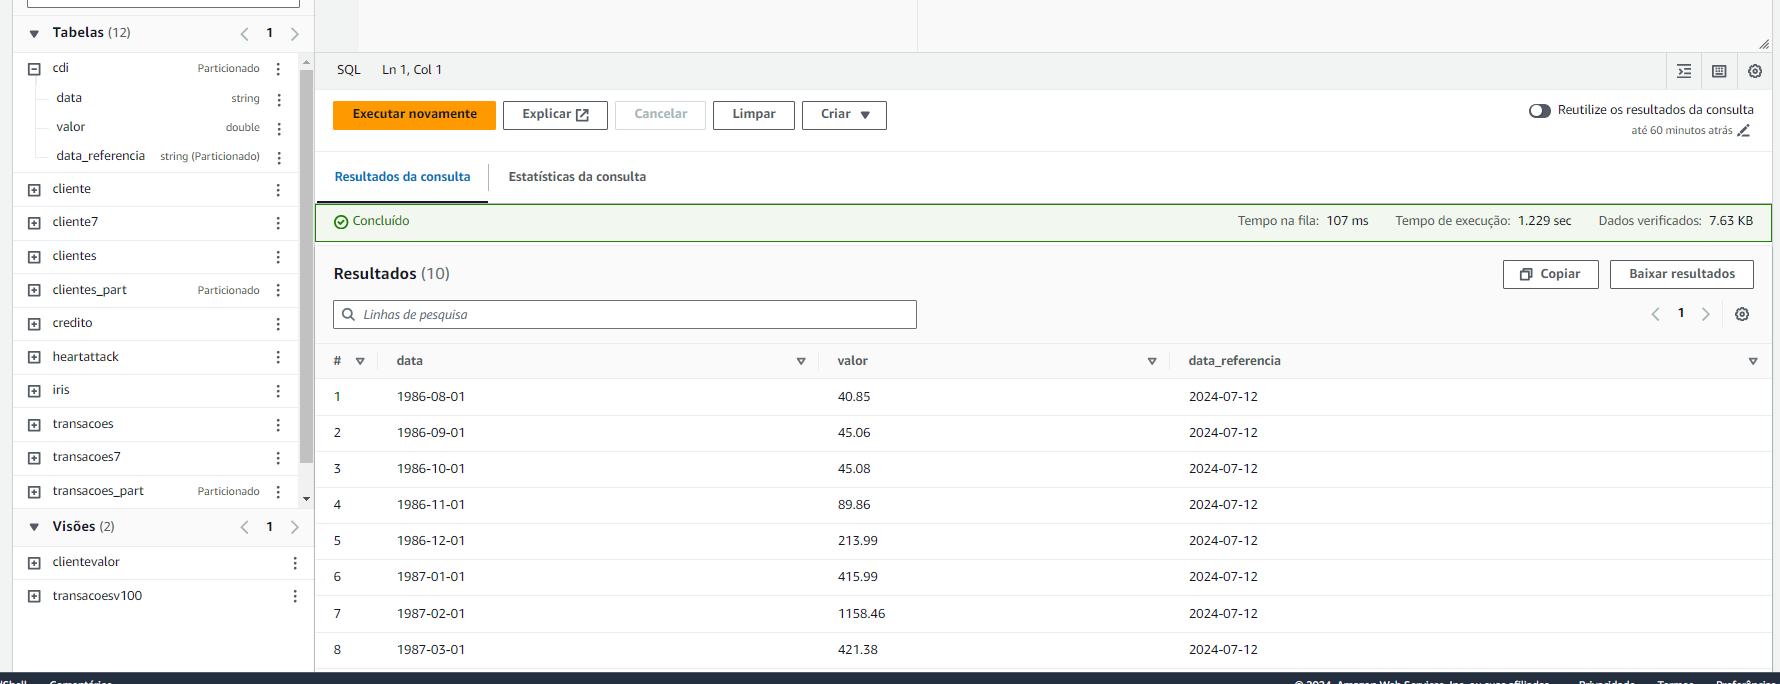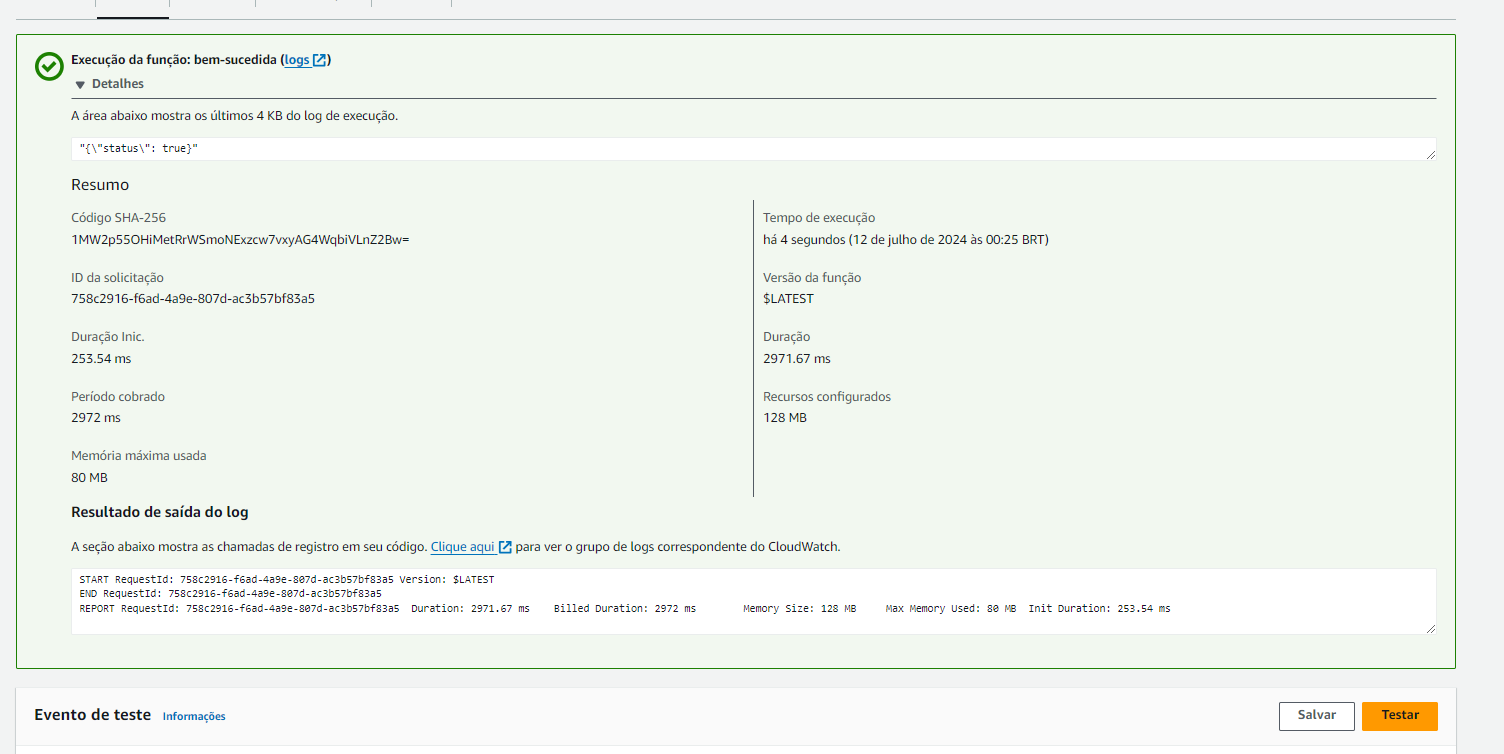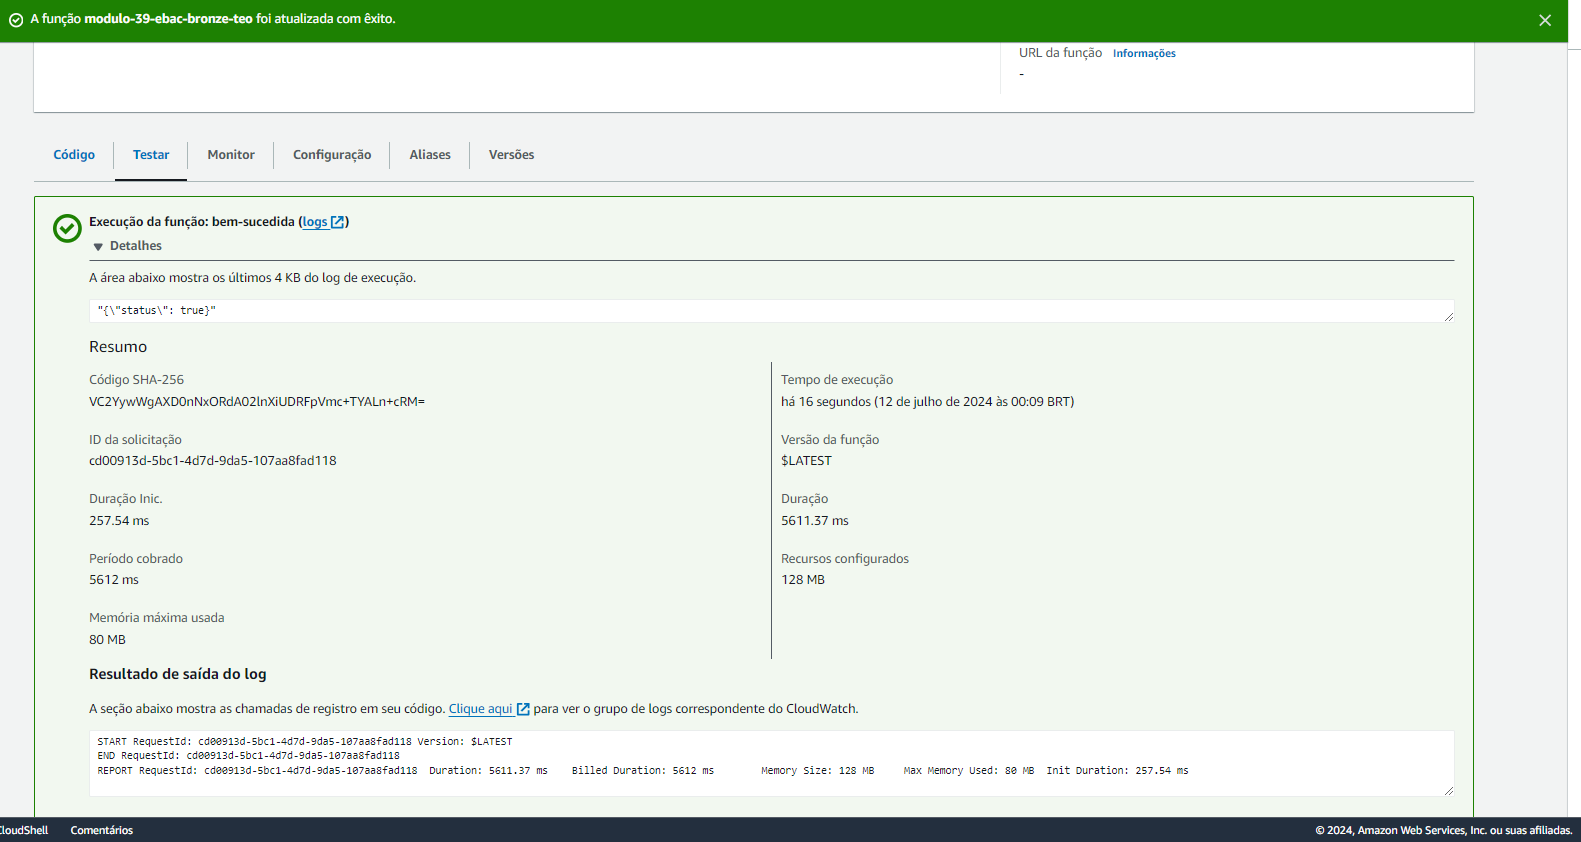

Replique as atividades do item 1.3 em sua conta.

## 2\. AWS Step Functions

- Criar uma `state machine` com três *tasks*, uma com cada função lambda criada na item 1.3.

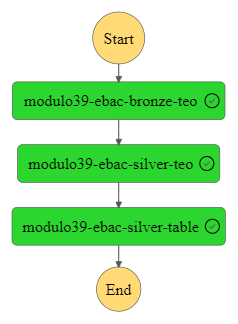

Replique as atividades do item 2.3 em sua conta.


## 3\. AWS EventBridge

Replique as atividades do item 3.3 em sua conta.

 **Criar um evento que inicie a *state machine* do item 2.3.**

*Criar uma regra no Amazon EventBridge*
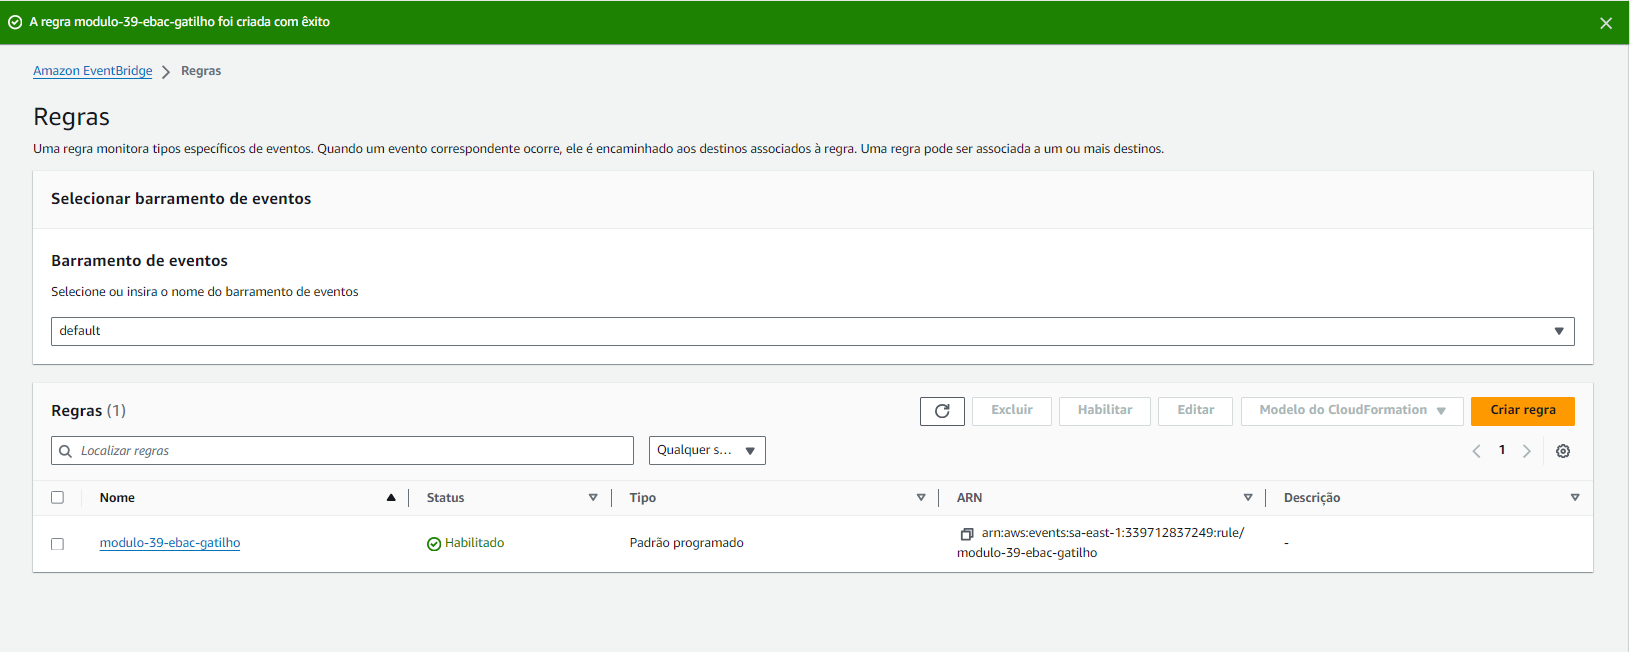